#**MtioClassifier**

**Objective:** To train ML models to classify the healthy and dysfunctional mitochondria from the scRNA dataset

- Train multiple classifiers - RandomForest, Logistic Regression and

In [ ]:
# Step 0: Install any missing libraries
!pip install xgboost --quiet

In [ ]:
# Step 0: Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay,precision_score, recall_score, f1_score, roc_curve, auc

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from google.colab import drive

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Step 1: Load your dataset

# 1.1 Mounting google drive
drive.mount('/content/drive')

# 1.2 Loading the dataset
file_path = "/content/drive/MyDrive/MitoProject/Mito_expression_data.csv"
df = pd.read_csv(file_path)

# 1.3 Preview
print(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                   Unnamed: 0     PUSL1  AURKAIP1    MRPL20  ATAD3B  ATAD3A  \
0  control_AAACCCAAGTTGCGAG-1  0.320841  0.921535  0.758401     0.0     0.0   
1  control_AAACCCACAAGACCTT-1  0.000000  0.000000  0.000000     0.0     0.0   
2  control_AAACCCACACCCAATA-1  0.000000  1.067352  1.067352     0.0     0.0   
3  control_AAACCCACATTGACCA-1  0.000000  0.000000  1.544208     0.0     0.0   
4  control_AAACCCAGTACTGTTG-1  0.000000  0.385211  0.385211     0.0     0.0   

   ACOT7   DNAJC11     PARK7  SLC25A33  ...   MT-ATP8   MT-ATP6    MT-CO3  \
0    0.0  0.320841  1.777952  0.320841  ...  1.061752  4.387513  4.314361   
1    0.0  0.000000  0.855301  0.000000  ...  0.855301  4.642064  4.487347   
2    0.0  0.000000  1.571806  0.000000  ...  2.355020  4.297169  3.923940   
3    0.0  0.000000  1.044554  0.000000  ...  0.000000  4.689186  4.523802   
4    0.0  0

In [ ]:
# Step 2: Preprocessing the data

# 2.1 Drop the cell ID column
df.drop(columns=['Unnamed: 0'], inplace=True)

# 2.2 Encode target labels
le = LabelEncoder()
df['condition'] = le.fit_transform(df['condition'])

# 2.3 Split features and labels
X = df.drop(columns=['condition'])
y = df['condition']

# 2.4 Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2.5 Preview the data
print(df.head())

      PUSL1  AURKAIP1    MRPL20  ATAD3B  ATAD3A  ACOT7   DNAJC11     PARK7  \
0  0.320841  0.921535  0.758401     0.0     0.0    0.0  0.320841  1.777952   
1  0.000000  0.000000  0.000000     0.0     0.0    0.0  0.000000  0.855301   
2  0.000000  1.067352  1.067352     0.0     0.0    0.0  0.000000  1.571806   
3  0.000000  0.000000  1.544208     0.0     0.0    0.0  0.000000  1.044554   
4  0.000000  0.385211  0.385211     0.0     0.0    0.0  0.385211  0.879533   

   SLC25A33      MFN2  ...   MT-ATP8   MT-ATP6    MT-CO3    MT-ND3   MT-ND4L  \
0  0.320841  0.320841  ...  1.061752  4.387513  4.314361  3.923072  1.061752   
1  0.000000  0.000000  ...  0.855301  4.642064  4.487347  4.340118  1.309458   
2  0.000000  0.000000  ...  2.355020  4.297169  3.923940  3.321698  1.571806   
3  0.000000  0.000000  ...  0.000000  4.689186  4.523802  4.384668  1.325268   
4  0.000000  0.385211  ...  1.340132  4.090012  3.928133  3.909463  1.819565   

     MT-ND4    MT-ND5    MT-ND6    MT-CYB  conditi

In [ ]:
# Step 3: Defining the models and parameters

# 3.1 Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# 3.2 Define models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(solver='saga', max_iter=1000, penalty='elasticnet', l1_ratio=0.5),
    'SVM': SVC(kernel='linear', probability=True),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

param_grids = {
    'Random Forest': {
        'n_estimators': [100],
        'max_depth': [10, None]
    },
    'Logistic Regression': {
        'C': [1.0]
    },
    'SVM': {
        'C': [1]
    },
    'Decision Tree': {
        'max_depth': [5, None]
    }
}
# 3.4 Cross-validation and model training
best_models = {}
results = {}
metric_summary = []

for name, model in models.items():
    print(f"\n🔧 Tuning {name}")
    grid = GridSearchCV(model, param_grids[name], cv=3, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    best_models[name] = best_model

    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results[name] = {
        'accuracy': acc,
        'roc_auc': auc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'conf_matrix': confusion_matrix(y_test, y_pred),
        'report': classification_report(y_test, y_pred, output_dict=True)
    }

    metric_summary.append({
        'Model': name,
        'Accuracy': acc,
        'AUC': auc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    })



🔧 Tuning Random Forest

🔧 Tuning Logistic Regression

🔧 Tuning SVM


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔧 Tuning Decision Tree


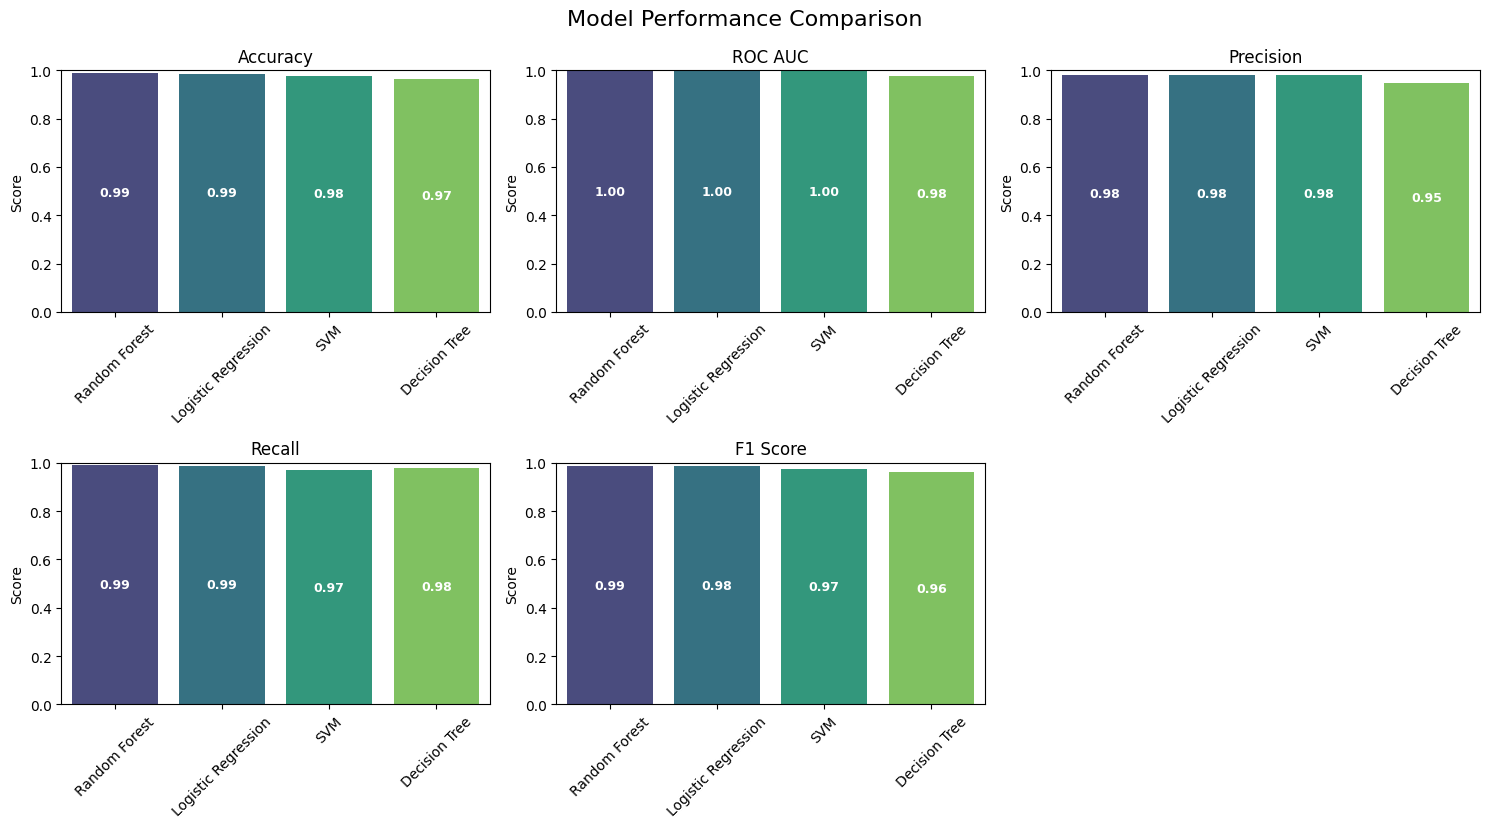

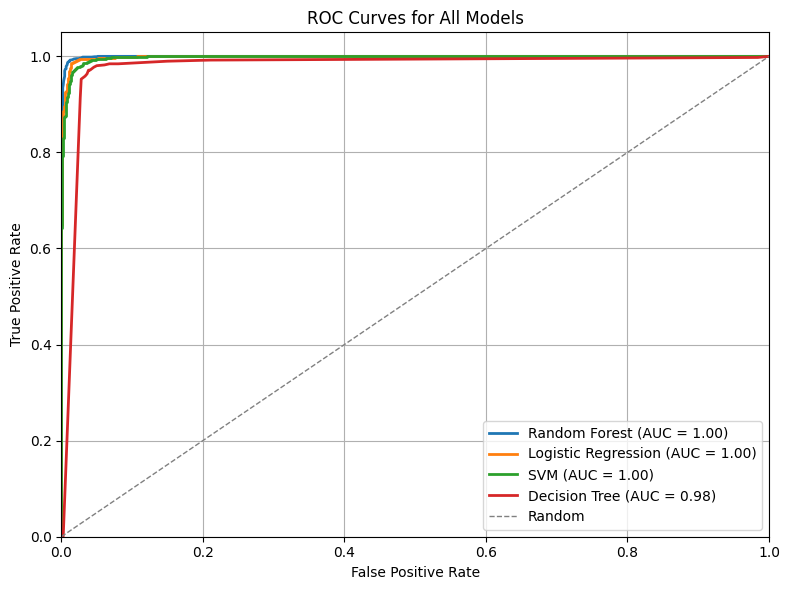

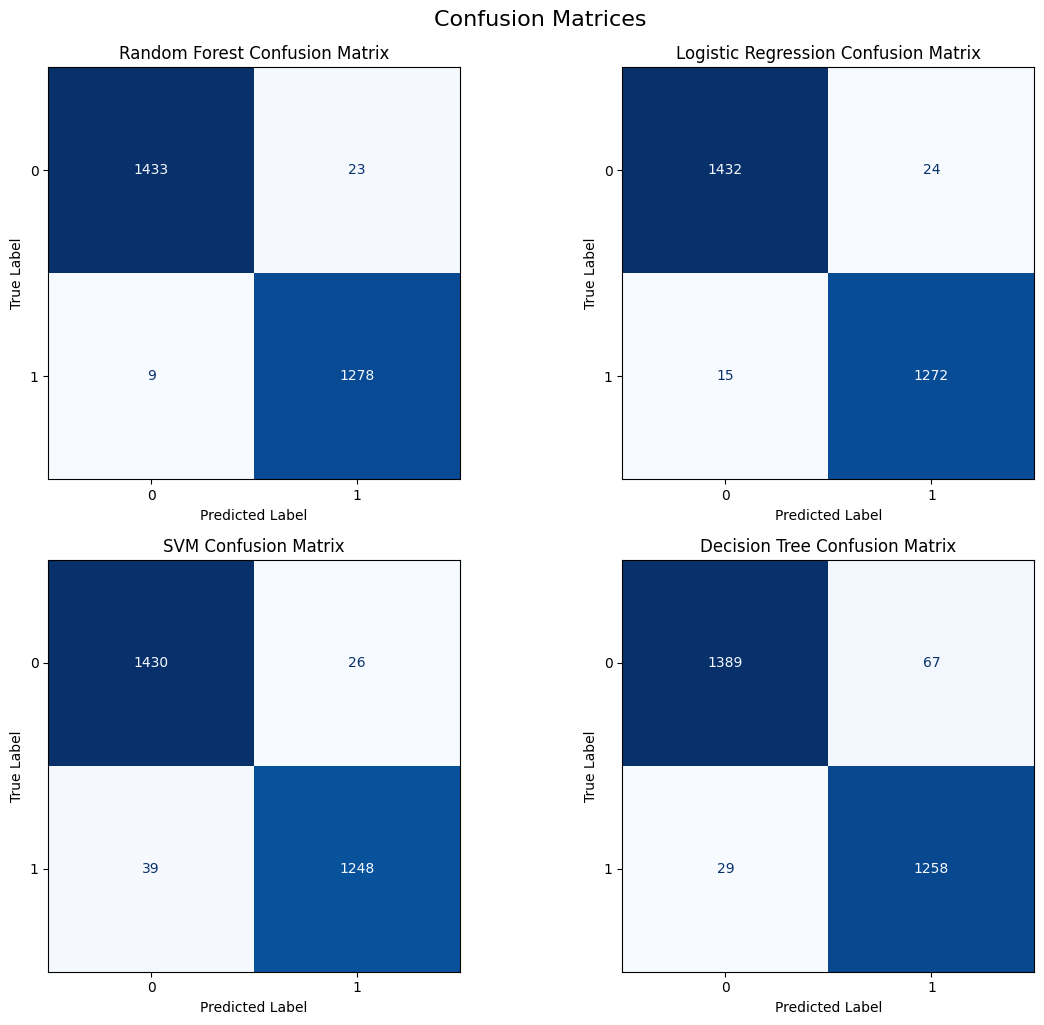

In [ ]:
# Step 4: Plotting the Results

# 4.1 Extract metrics
metrics = {
    'Accuracy': [results[m]['accuracy'] for m in results],
    'ROC AUC': [results[m]['roc_auc'] for m in results],
    'Precision': [results[m]['precision'] for m in results],
    'Recall': [results[m]['recall'] for m in results],
    'F1 Score': [results[m]['f1_score'] for m in results]
}

models_list = list(results.keys())

# 4.2 Plot with value annotations
plt.figure(figsize=(15, 8))

for idx, (metric_name, values) in enumerate(metrics.items(), 1):
    plt.subplot(2, 3, idx)
    ax = sns.barplot(x=models_list, y=values, palette='viridis')
    plt.title(metric_name)
    plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.xticks(rotation=45)

    # Add value labels on top of each bar
    for i, v in enumerate(values):
        ax.text(i, v / 2, f"{v:.2f}", ha='center', va='center', color='white', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.suptitle("Model Performance Comparison", fontsize=16, y=1.03)
plt.show()

# 4.3 Plot ROC curves
plt.figure(figsize=(8, 6))

for name, model in best_models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# 4.4 Plot Confusion Matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, (name, data) in enumerate(results.items()):
    cm = data['conf_matrix']
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[idx], cmap='Blues', colorbar=False)
    axes[idx].set_title(f"{name} Confusion Matrix")
    axes[idx].set_xlabel("Predicted Label")
    axes[idx].set_ylabel("True Label")

plt.tight_layout()
plt.suptitle("Confusion Matrices", fontsize=16, y=1.02)
plt.show()

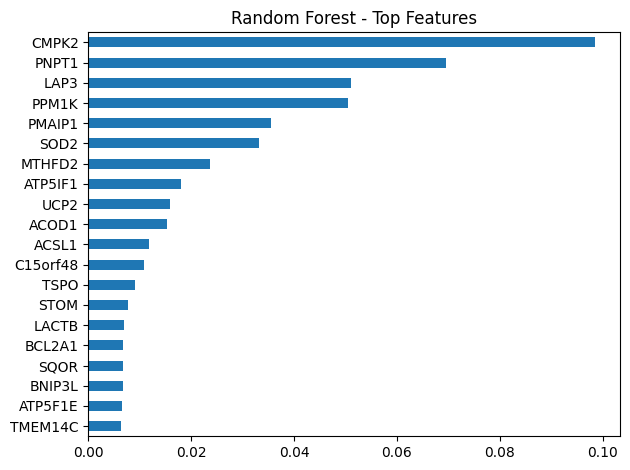

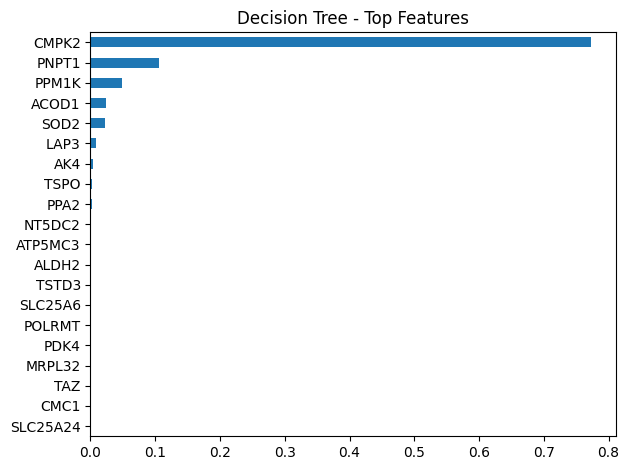

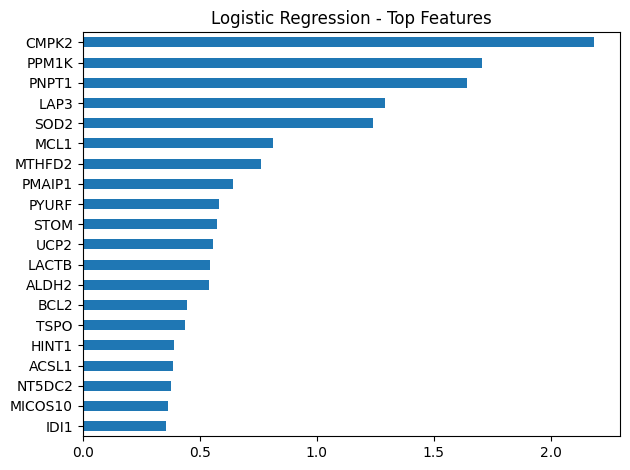

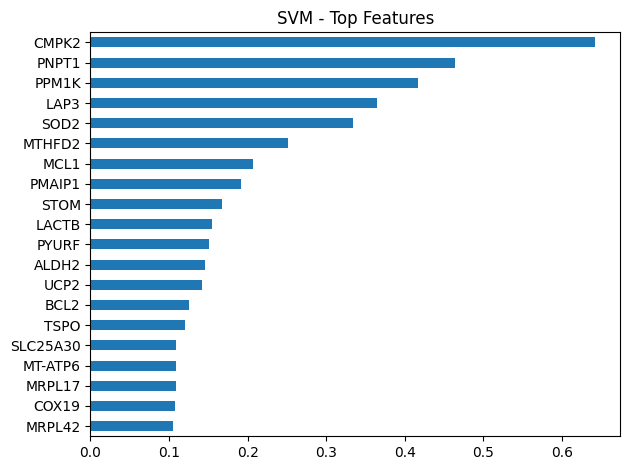

In [ ]:
# Step 5: Extracting the top features for each model

feature_importances = {}

# 5.1 Random Forest and Decision Tree
for model_name in ['Random Forest', 'Decision Tree']:
    importances = pd.Series(best_models[model_name].feature_importances_, index=X.columns)
    feature_importances[model_name] = importances.sort_values(ascending=False).head(20)
    feature_importances[model_name].plot(kind='barh', title=f"{model_name} - Top Features")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# 5.2 Logistic Regression and SVM
for model_name in ['Logistic Regression', 'SVM']:
    coef = best_models[model_name].coef_[0]
    importances = pd.Series(np.abs(coef), index=X.columns)
    feature_importances[model_name] = importances.sort_values(ascending=False).head(20)
    feature_importances[model_name].plot(kind='barh', title=f"{model_name} - Top Features")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [ ]:
# Step 6: Summary and exporting the top 10 genes

# 6.1 Extracting the top genes from all models
top_genes_all = pd.concat([feature_importances[m] for m in feature_importances], axis=1)
top_genes_all['mean_importance'] = top_genes_all.mean(axis=1)
top_genes_all = top_genes_all.sort_values(by='mean_importance', ascending=False)

top_genes_all.columns = [ 'RF', 'DT', 'LR', 'SVM', 'Mean_importance']
print(top_genes_all.head())


# 6.2 Exporting the top 10 genes
export_path = "/content/drive/MyDrive/MitoProject/top_mito_genes_for_GO.csv"
top_genes_all.head(10).to_csv(export_path)
print("\n Top features saved for GO analysis (10 genes).")

             RF        DT        LR       SVM  Mean_importance
CMPK2  0.098444  0.772143  2.186492  0.641828         0.924727
PNPT1  0.069493  0.105759  1.640487  0.463778         0.569879
PPM1K  0.050423  0.048422  1.704543  0.417286         0.555169
MCL1        NaN       NaN  0.812854  0.206502         0.509678
LAP3   0.051054  0.009096  1.292395  0.365275         0.429455

 Top features saved for GO analysis (10 genes).
